In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib widget
matplotlib.rc('font', size=18)
import uncertainties as unc
import scipy.special as ss

from tqdm.notebook import tqdm

import sys
sys.path.append('../')
import general_purpose.utilities as ut
import general_purpose.uplotlib as uplt

from importlib import reload

import reconstruct as rec

In [6]:
def get_run(folder):
    run = {'rec_dict': ut.json2dict(f'{folder}/reconstructed.json')}
    
    run['observables'] = {}
    for rname, r in run['rec_dict']['members'].items():
        last_segment_traj = np.load(f"{folder}/{run['rec_dict']['folders'][-1]}/{r['ancestry'][-1]}-traj.npy")
        run['observables'][rname] = last_segment_traj[-1,1]
        
    return run

def expectation(run, func, **kwargs):
    _f = np.array([func(x, **kwargs) for x in run['observables'].values()])
    _w = np.array([r['weight'] for r in run['rec_dict']['members'].values()])
    # _w = np.exp(-np.array([r['cum_log_escore'] for r in rec_dict['members'].values()]))
    # _n = np.exp(rec_dict['cum_log_norm_factor'])

    mean = np.mean(_f*_w)
    std = np.sqrt(np.mean(_f*_w**2)/len(_w))

    return unc.ufloat(mean,std)

In [10]:
def f(x, a):
    return float(x>a)

lam = 1
sig = 1
def ou_var(t):
    return sig**2/(2*lam)*(1 - np.exp(-2*lam*t))

cum_gaus = lambda x: 0.5*(1 + ss.erf(x/np.sqrt(2)))

overcoming_prob = lambda x,v: cum_gaus(-x/np.sqrt(v))

v = ou_var(2)

In [29]:
runs = [get_run(f'./__test__/f{i}--k__4--nens__999--T__10') for i in range(4)]

In [30]:
a = np.linspace(0,4,101)

es = [np.array([expectation(run, f, a=_a) for _a in a]) for run in runs]
e_th = overcoming_prob(a,v)

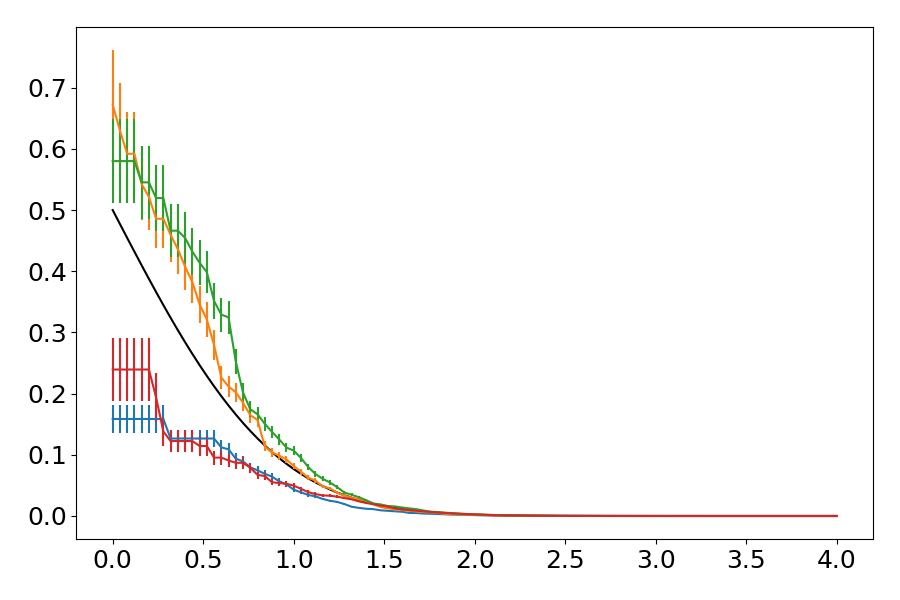

In [31]:
plt.close(2)
fig,ax = plt.subplots(num=2, figsize=(9,6))

plt.plot(a, e_th, color='black')

for e in es:
    uplt.plot(a,e)
# plt.plot(a,uplt.std_dev(e)/uplt.nominal_value(e))

fig.tight_layout()

In [37]:
n_es = np.vstack([uplt.nominal_value(e) for e in es])
print(n_es.shape)

(4, 101)


In [47]:
m_es = uplt.avg(n_es, axis=0)
relative_error = np.sqrt(np.mean((n_es/m_es - 1)**2, axis=0))

TypeError: avg() got an unexpected keyword argument 'axis'

/tmp/ipykernel_2785929/51523595.py:5: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(a, uplt.std_dev(e)/uplt.nominal_value(e))
/tmp/ipykernel_2785929/51523595.py:5: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(a, uplt.std_dev(e)/uplt.nominal_value(e))


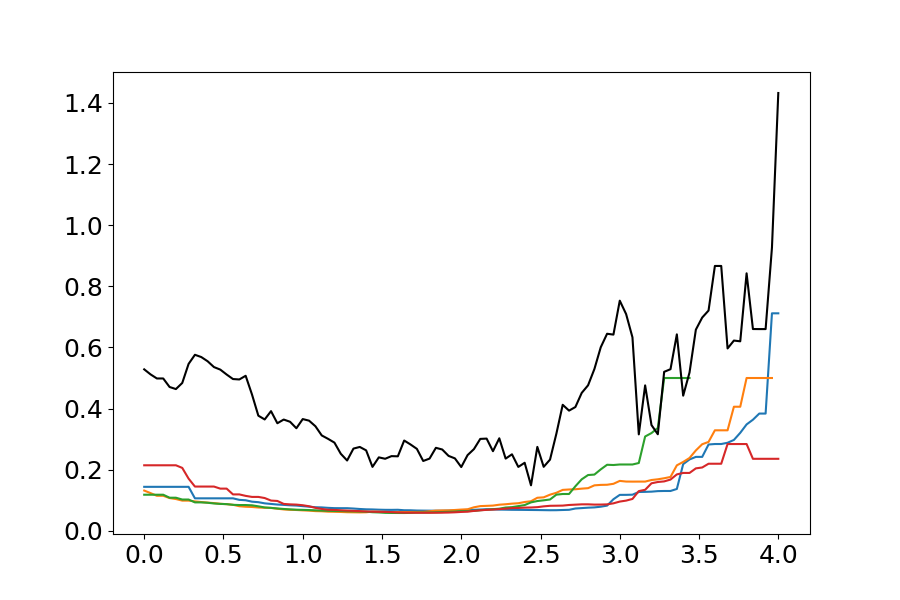

In [44]:
plt.close(3)
fig,ax = plt.subplots(num=3, figsize=(9,6))

for e in es:
    plt.plot(a, uplt.std_dev(e)/uplt.nominal_value(e))

plt.plot(a, relative_error, color='black')

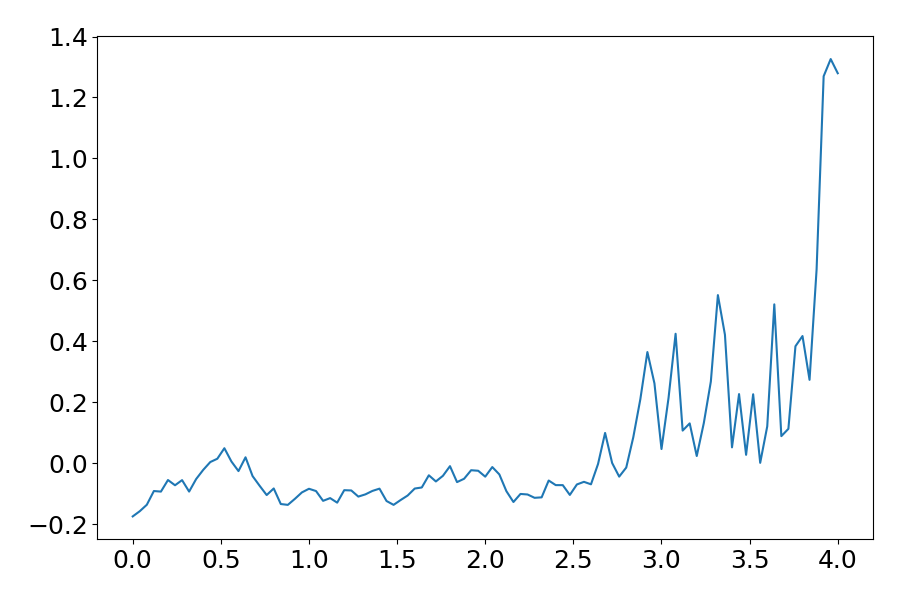

In [46]:
plt.close(4)
fig,ax = plt.subplots(num=4, figsize=(9,6))

plt.plot(a, m_es/e_th - 1)

fig.tight_layout()